In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import warnings
warnings.simplefilter("ignore")

- [The Catalog site](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermilgrb&Action=More+Options)
- [Feature key](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermilgrb.html)

Only enforced parameter at query-level is that redshift "=null"


You can check a burst's GBM signatures by putting its name into the [GRB burst catalog](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermigbrst&Action=More+Options) and selecting the data products option "D".

In [2]:
dat = Table.read('RS=null.fits')
targets = dat.to_pandas()

# Remove trailing whitespace
targets = targets.rename(columns=lambda x: x.strip().lower())

targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Columns: 107 entries, name to gbm_cat_fluence_error
dtypes: float64(101), int16(2), object(4)
memory usage: 153.4+ KB


In [39]:
# Apply the flux_ratio calculations
targets['flux_ratio'] = targets['like_gbm_flux']/targets['like_lat_flux']
targets['flux_ene_ratio'] = targets['like_gbm_flux_ene']/targets['like_lat_flux_ene']
targets['fluence_ratio'] = targets['like_gbm_fluence']/targets['like_lat_fluence']

def propagate_error(a, b, e_a, e_b):
    return np.abs(a/b) * np.sqrt( (e_a/a)**2 + (e_b/b) )

targets['flux_ratio_error'] = propagate_error(targets['like_gbm_flux'],
                                              targets['like_lat_flux'],
                                              targets['like_gbm_flux_error'],
                                              targets['like_lat_flux_error'])

targets['flux_ene_ratio_error'] = propagate_error(targets['like_gbm_flux_ene'],
                                                  targets['like_lat_flux_ene'],
                                                  targets['like_gbm_flux_ene_error'],
                                                  targets['like_lat_flux_ene_error'])

targets['fluence_ratio_error'] = propagate_error(targets['like_gbm_fluence'],
                                                  targets['like_lat_fluence'],
                                                  targets['like_gbm_fluence_error'],
                                                  targets['like_lat_fluence_error'])

# Generate time difference calculation
targets['like_gbm-lat_time_difference'] = targets['like_gbm_t0'] - targets['like_lat_t0']
targets['gbm-lle_time_difference'] = targets['gbm_cat_t05'] - targets['lle_t90']

targets.T.tail(5).T.describe()

,flux_ene_ratio_error,fluence_ratio_error,gbm-lat_time_difference,like_gbm-lat_time_difference,gbm-lle_time_difference
count,128.0,128.0,186.0,186.0,186.0
unique,115.0,115.0,178.0,178.0,142.0
top,0.0,0.0,0.0,0.0,0.0
freq,14.0,14.0,7.0,7.0,11.0


The original method simply extracted all sources with a gbm-lat_time_difference > 0.

In [43]:
original_targets = targets[ targets['gbm-lat_time_difference'] > 0 ]

original_targets[['like_gbm-lat_time_difference', 'gbm-lle_time_difference', 
                  'lle_t90', 'fluence_ratio', 'flux_ratio',
         'flux_ene_ratio', 'tl100', 'Like_LAT_GRBIndex'.lower(), 'gbm_cat_t90']].corr()

,like_gbm-lat_time_difference,gbm-lle_time_difference,lle_t90,fluence_ratio,flux_ratio,flux_ene_ratio,tl100,like_lat_grbindex,gbm_cat_t90
like_gbm-lat_time_difference,1.000000,0.883330,0.652774,-0.360266,-0.085024,-0.083995,0.226738,-0.207656,0.177010
gbm-lle_time_difference,0.883330,1.000000,0.368750,-0.113933,-0.331636,-0.260577,-0.126596,-0.282277,-0.111074
lle_t90,0.652774,0.368750,1.000000,-0.678517,0.388889,0.313331,0.549679,-0.092251,0.284909
fluence_ratio,-0.360266,-0.113933,-0.678517,1.000000,-0.571144,-0.488411,-0.353920,-0.648098,0.254352
flux_ratio,-0.085024,-0.331636,0.388889,-0.571144,1.000000,0.973617,0.598289,0.585887,0.170301
flux_ene_ratio,-0.083995,-0.260577,0.313331,-0.488411,0.973617,1.000000,0.453961,0.454122,0.054392
tl100,0.226738,-0.126596,0.549679,-0.353920,0.598289,0.453961,1.000000,-0.166795,0.786650
like_lat_grbindex,-0.207656,-0.282277,-0.092251,-0.648098,0.585887,0.454122,-0.166795,1.000000,-0.247354
gbm_cat_t90,0.177010,-0.111074,0.284909,0.254352,0.170301,0.054392,0.786650,-0.247354,1.000000


In [60]:
targets['gbm_cat_t90'].sort_values(ascending=True)[0:20]

targets.loc[ targets['gbm_cat_t90'] < 1].sort_values('fluence_ratio')

,name,gcn_name,time,trigger_met,ra,dec,lii,bii,error_radius,redshift,...,gbm_cat_fluence_error,flux_ratio,flux_ene_ratio,fluence_ratio,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,gbm-lat_time_difference,like_gbm-lat_time_difference,gbm-lle_time_difference
12,b'GRB170127067 ',b'GRB170127C ',57780.066516,5.071738e+08,338.98,-63.97,324.0439,-47.2212,0.52,0.0,...,5.319100e-08,0.000000,0.000000,0.000000,NaN,NaN,NaN,-664.76001,-664.76001,0.000
22,b'GRB160829334 ',b'GRB160829A ',57629.334456,4.941505e+08,201.72,-56.78,307.7972,5.7566,0.10,0.0,...,1.105100e-08,0.000000,0.000000,0.000000,NaN,NaN,NaN,-0.95000,-0.95000,-0.064
66,b'GRB200415367 ',b'GRB200415A ',58954.366725,6.086333e+08,11.08,-25.00,85.6272,-87.3384,0.56,0.0,...,1.615400e-08,0.000000,0.000000,0.000000,NaN,NaN,NaN,-19.18000,-19.18000,-0.016
98,b'GRB190606080 ',b'GRB190606A ',58640.079942,5.814789e+08,76.54,-0.68,200.8654,-23.5771,0.47,0.0,...,1.340000e-08,0.000000,0.000000,0.000000,NaN,NaN,NaN,-31.60000,-31.60000,-0.101
113,b'GRB160702516 ',b'GRB160702A ',57571.515556,4.891549e+08,231.09,9.07,13.6812,49.6630,0.21,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,NaN,-1941.52002,-1941.52002,0.000
110,b'GRB140402007 ',b'GRB140402A ',56749.007014,4.180902e+08,207.66,5.97,339.2299,64.5844,0.16,0.0,...,2.900800e-08,90.236203,23.121148,0.103421,71.324275,31.082109,0.139030,-0.23800,-0.23800,-1.674
169,b'GRB120915000 ',b'GRB120915A ',56185.000474,3.693600e+08,240.95,57.04,88.0620,44.9119,1.76,0.0,...,2.547600e-08,0.467351,0.129133,0.126068,0.332156,0.114388,0.111673,-0.55000,-0.55000,-0.320
115,b'GRB171011810 ',b'GRB171011C ',58037.810035,5.294428e+08,168.48,10.03,244.9302,61.3609,0.82,0.0,...,1.449500e-08,137.225416,86.950316,0.281154,79.850034,109.907527,0.355388,-0.49894,-0.49894,-0.448
58,b'GRB120830297 ',b'GRB120830A ',56169.296562,3.680032e+08,88.59,-28.79,234.1716,-24.3213,0.62,0.0,...,2.718800e-08,5.740205,3.920481,0.350574,4.979013,6.716713,0.600617,-0.66000,-0.66000,0.000
128,b'GRB081024891 ',b'GRB081024B ',54763.890741,2.465762e+08,323.01,20.84,72.5531,-21.9686,0.31,0.0,...,2.864600e-08,1.729017,1.647275,0.521911,1.187962,1.983677,0.628494,-0.23400,-0.23400,-1.384


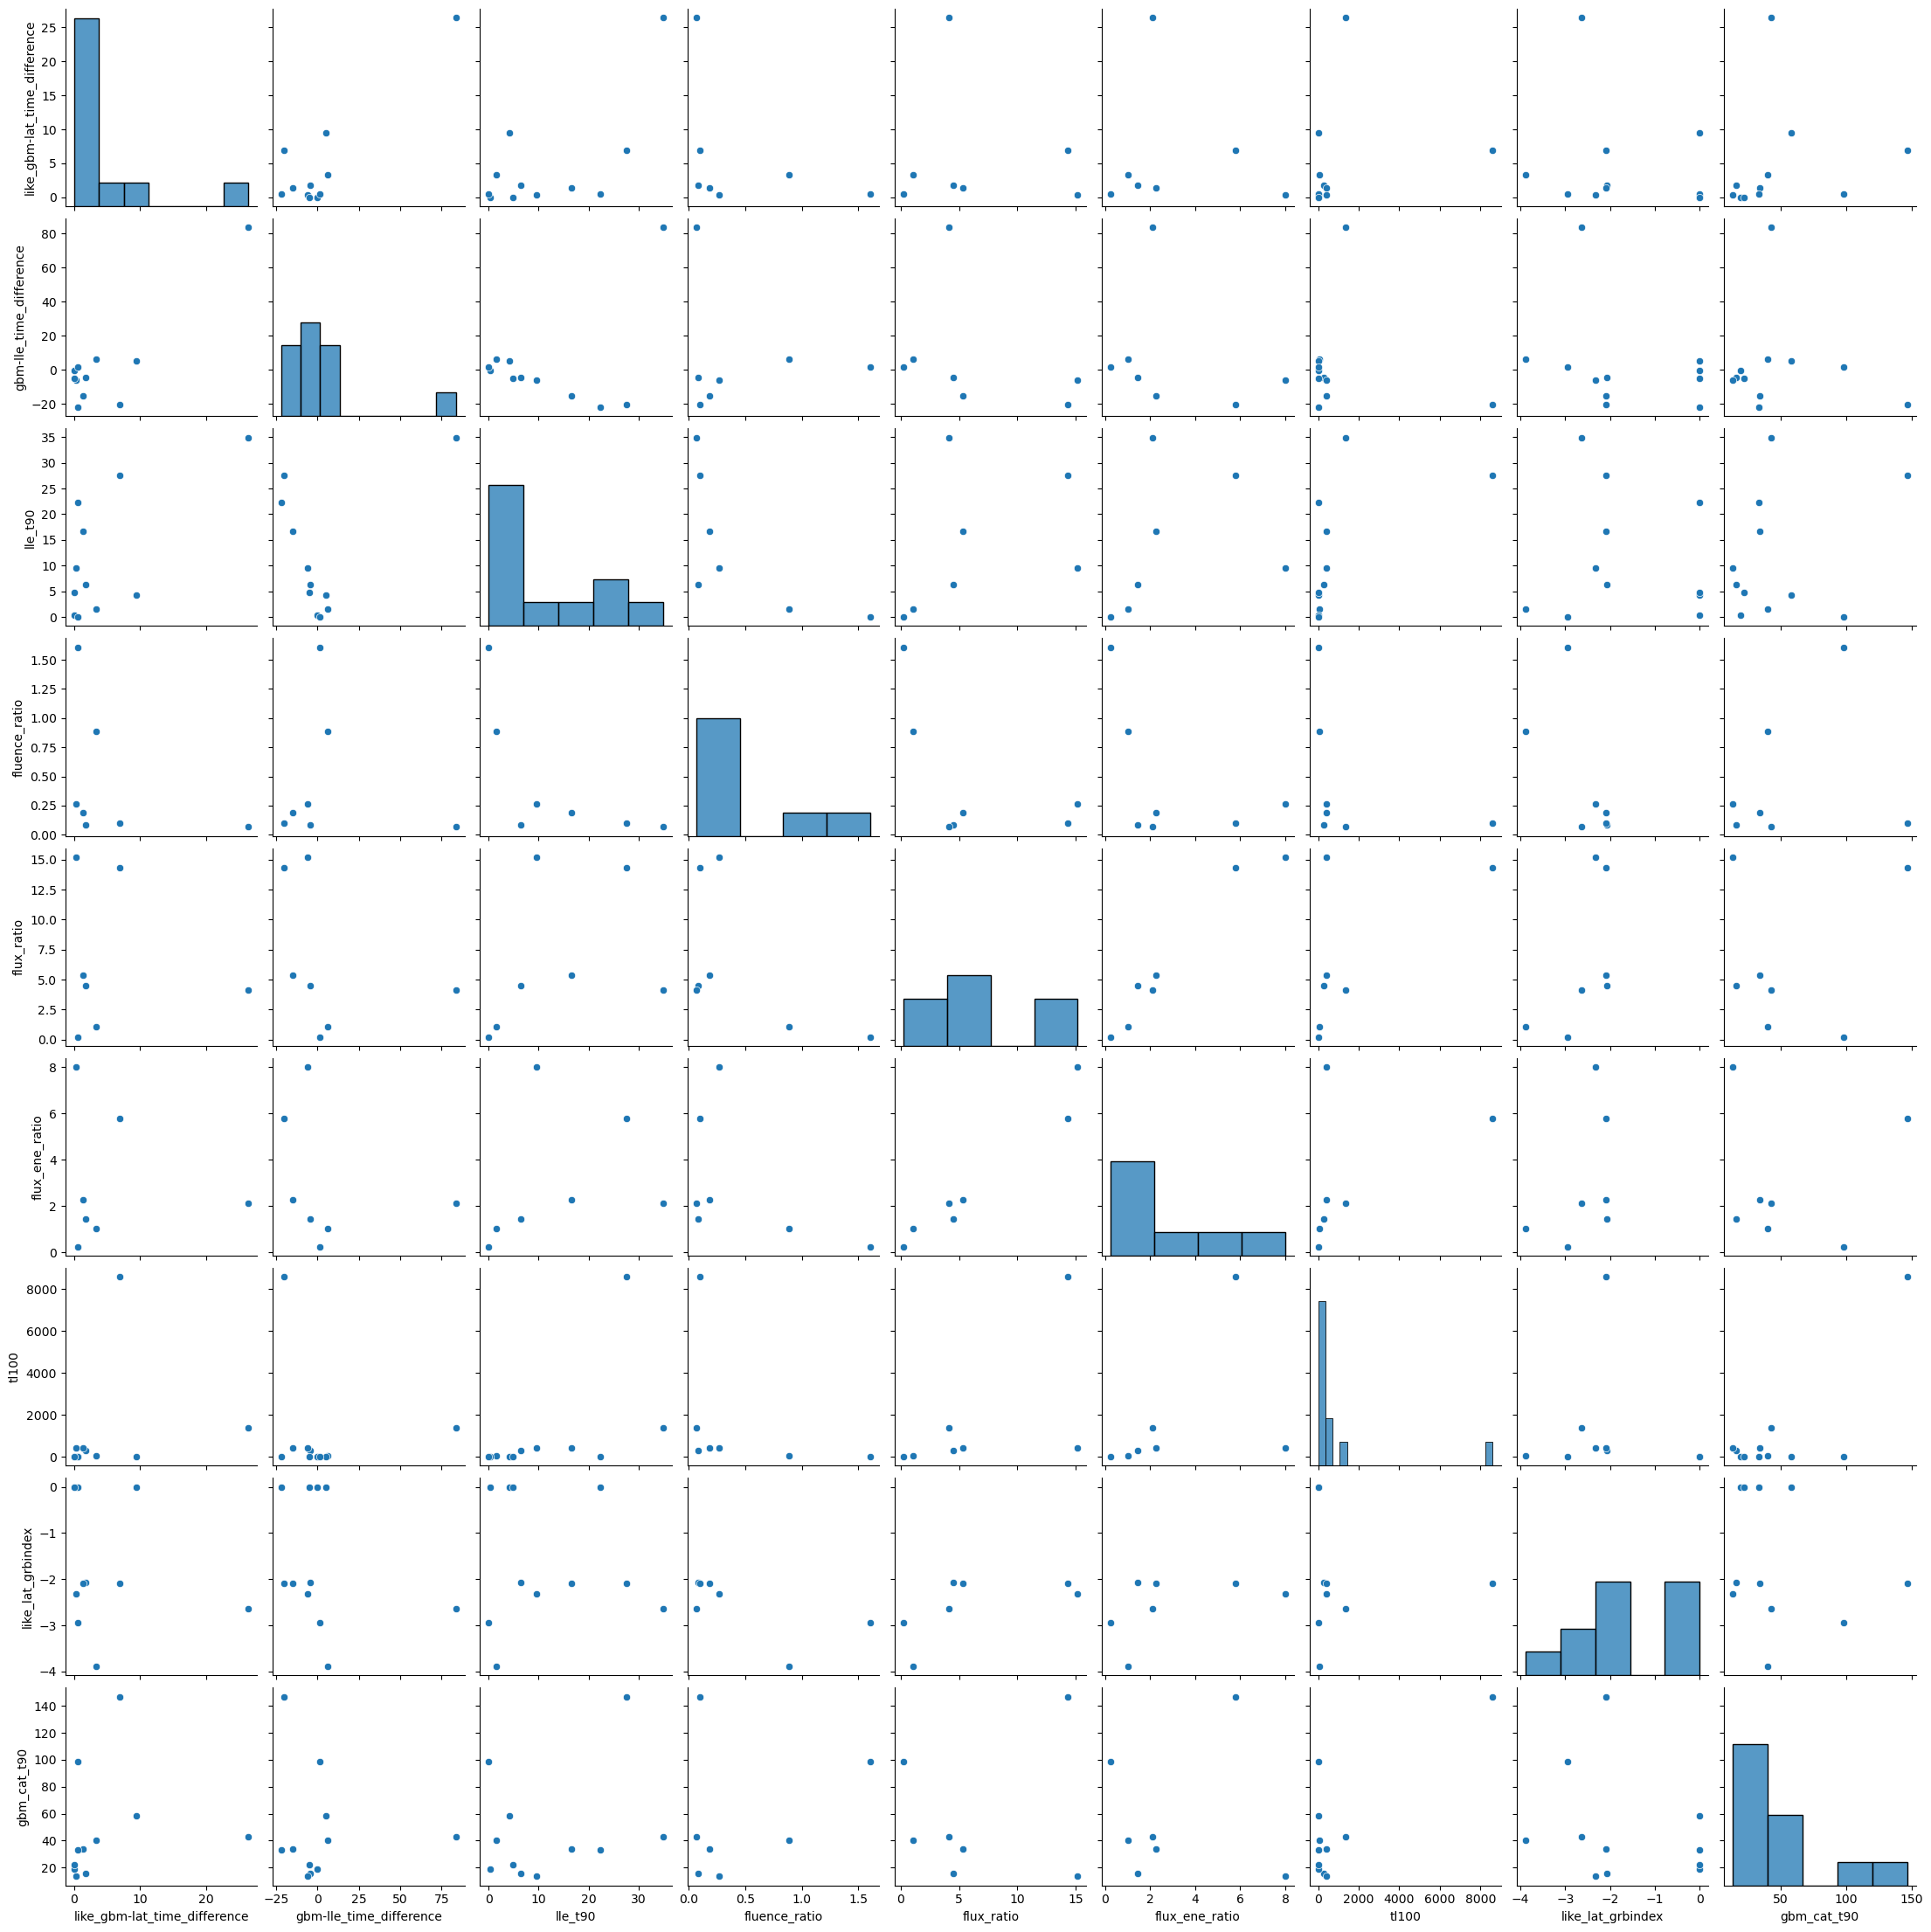

In [61]:
sns.pairplot(original_targets[['like_gbm-lat_time_difference', 'gbm-lle_time_difference', 
                  'lle_t90', 'fluence_ratio', 'flux_ratio',
         'flux_ene_ratio', 'tl100', 'Like_LAT_GRBIndex'.lower(), 'gbm_cat_t90']])

There should be a negative correlation between burst duration and corresponding fluence ratio (0927-6505(96)00018-7, Figure 2.)

(-0.1, 5.0)

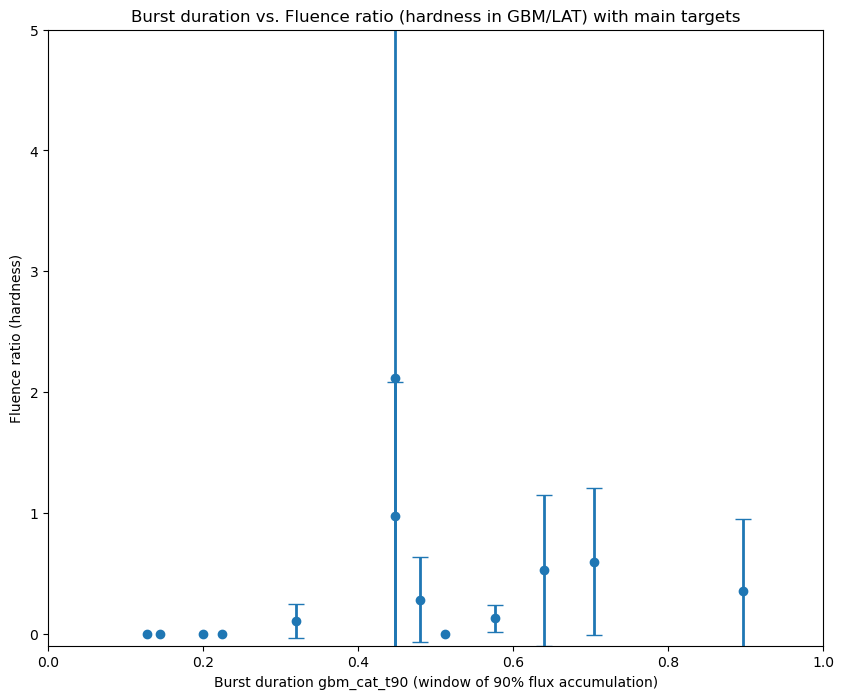

In [59]:
fig, ax = plt.subplots()
ax.errorbar(x = targets['gbm_cat_t90'], y=targets['fluence_ratio'], 
            yerr = targets['fluence_ratio_error'], fmt = 'o', linewidth = 2, capsize = 6)
ax.set_xlabel('Burst duration gbm_cat_t90 (window of 90% flux accumulation)')
ax.set_ylabel('Fluence ratio (hardness)')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Fluence ratio (hardness in GBM/LAT) with main targets')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0,1)
ax.set_ylim(-.1,5)

Try to see if the considered correlation does exist by seeing if there's that negative correlation.

In [6]:
# Polyfit does not like NaNs or infs
print('Dropping %s targets for inf fluence_ratio'% len(targets.loc[targets['fluence_ratio'] == np.inf]) )
targets = targets.loc[ targets['fluence_ratio'] != np.inf ]
print('Dropping %s targets for NaN fluence_ratio'% len(targets.loc[ np.isnan(targets['fluence_ratio']) ]) )
targets = targets.loc[ ~np.isnan(targets['fluence_ratio']) ]

# These ones will have had a 0.0 in the LAT flux, causing a NaN
print('Dropping %s targets for NaN fluence_ratio_error'% len(targets.loc[ np.isnan(targets['flux_ratio_error']) ]) )
targets = targets.loc[ ~np.isnan(targets['fluence_ratio_error']) ]

# These ones will have had a 0.0 in GBM flux, causing a 0.
print('Dropping %s targets for 0. fluence_ratio_error'%len(targets[targets['flux_ratio_error'] ==0]))
targets = targets[targets['fluence_ratio_error'] !=0]

Dropping 8 targets for inf fluence_ratio
Dropping 7 targets for NaN fluence_ratio
Dropping 43 targets for NaN fluence_ratio_error
Dropping 14 targets for 0. fluence_ratio_error


Text(0.5, 0.01, 'Fluence ratio ~= hardness wrt. GBM and LAT -- GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)')

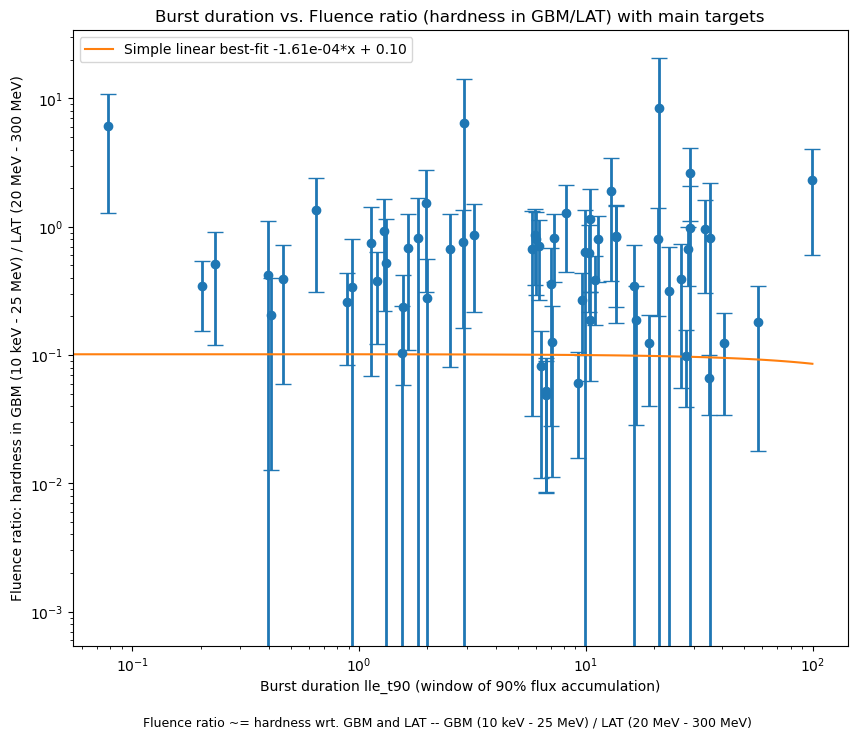

In [7]:
result = np.polyfit(x = targets['lle_t90'], y = targets['fluence_ratio'], 
                 deg = 1, w = 1/targets['fluence_ratio_error'], full=True)
fit = result[0]

fig, ax = plt.subplots()
ax.errorbar(x = targets['lle_t90'], y=targets['fluence_ratio'], 
            yerr = targets['fluence_ratio_error'], fmt = 'o', linewidth = 2, capsize = 6)
ax.set_xlabel('Burst duration lle_t90 (window of 90% flux accumulation)')
ax.set_ylabel('Fluence ratio: hardness in GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Fluence ratio (hardness in GBM/LAT) with main targets')
#ax.set_xscale('log')

stats = targets['lle_t90'].describe()

time_domain = np.linspace(stats['min'], stats['max'], 100)

ax.plot(time_domain, time_domain*fit[0] + fit[1] 
        , '-', label = 'Simple linear best-fit %.2e*x + %.2f'%(fit[0], fit[1]))
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.figtext(0.5, 0.01, 
            'Fluence ratio ~= hardness wrt. GBM and LAT -- GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)', 
            horizontalalignment='center', fontsize=9)

In [8]:
fig.savefig('Burst_duration_vs_hardness.png')

In [9]:
# Do we want the ones with the highest hardness value?
print('Sorted by hardness: ')
print(targets[['fluence_ratio', 'name', 'ra', 'dec', 'lle_t90']].sort_values(by='fluence_ratio', 
                                                                             ascending=False).head(20))
#targets.iloc[65]

# I want to get the smallest burst-duration one too
print('\nSorted by burst duration:')
print(targets[ targets['lle_t90']!=0.0 ][['lle_t90', 'name', 'ra', 'dec', 'fluence_ratio']].sort_values(
    by = 'lle_t90', ascending=True).head(20))
#targets.iloc[47] #0.71s source
#targets.iloc[77]
#targets.iloc[177]
#targets.iloc[98]
#targets.iloc[2]

Sorted by hardness: 
     fluence_ratio                 name      ra    dec  lle_t90
65        8.433630  b'GRB100826957    '  277.71 -25.27   21.087
144       6.426991  b'GRB180305393    '   49.67  32.10    2.894
77        6.069751  b'GRB130310840    '  142.38 -17.10    0.078
163       3.904246  b'GRB170306588    '  154.54  51.55    0.000
167       3.566120  b'GRB171102107    '  187.72  54.01    0.000
34        2.627453  b'GRB170906030    '  203.94 -47.12    0.000
162       2.604736  b'GRB120226871    '  302.97  48.98   28.926
183       2.306479  b'GRB100724029    '  123.59  75.86   99.807
142       2.289091  b'GRB161015710    '  269.13  30.16    0.000
184       2.113133  b'GRB141113346    '  182.32  77.38    0.000
156       1.982881  b'GRB111210359    '  122.51  44.09    0.000
161       1.894373  b'GRB190122305    '  258.71  48.12   12.911
78        1.811143  b'GRB101227406    '  240.21 -15.93    0.000
143       1.800486  b'GRB081102365    '  212.95  30.33    0.000
72        1.775366 

Time to focus a little on their angular distribution. Since the candidates aren't parsed down, the distribution won't mean too much. I'm curious, though, whether Cline's anomalous overdense region shows up.

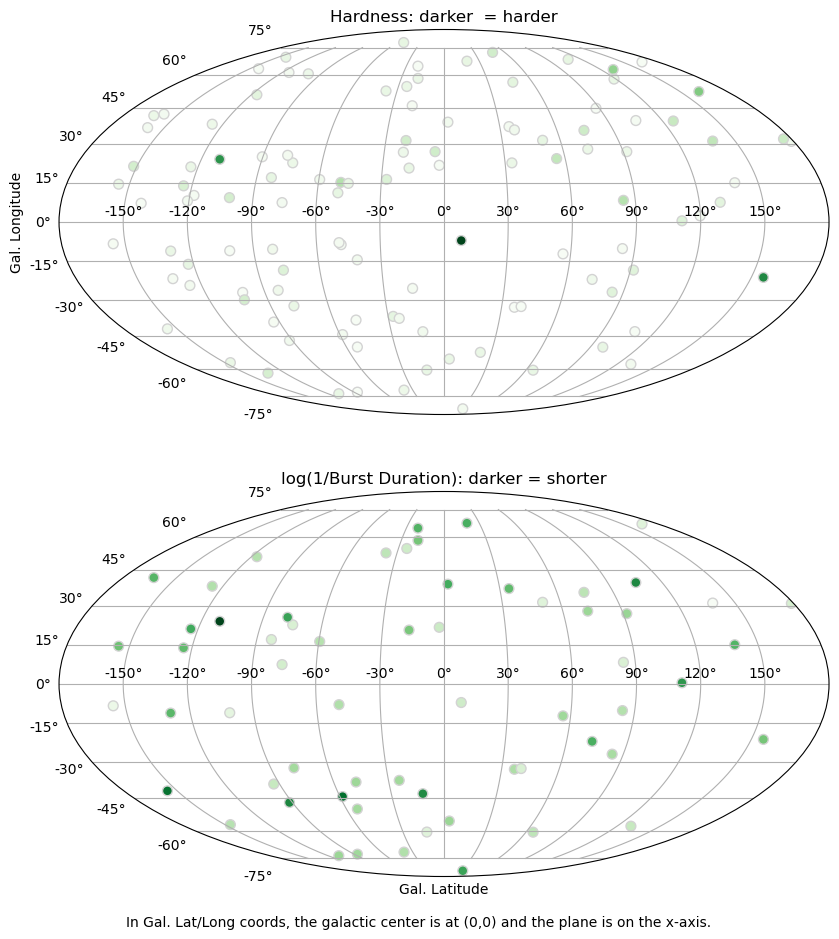

In [86]:
fig = plt.figure()
ax1 = fig.add_subplot(211, projection='mollweide')
plt.grid(True)
ax2 = fig.add_subplot(212, projection='mollweide')
plt.grid(True)

# change the >180s to negative
modified = targets.copy()
modified.loc[modified['lii']>180, 'lii'] -= (360)

fig.set_figwidth(20)
fig.set_figheight(11)

ax1.set_title('Hardness: darker  = harder')#, rotation=-90, position=(1, .5), ha='left', va='center')
ax1.scatter(modified['lii']*(np.pi/180), targets['bii']*(np.pi/180), 50, 
            c=targets['fluence_ratio'], cmap='Greens', edgecolors='lightgray')

# quick parse-out of the 0 t90s
nonzeros = targets[ targets['lle_t90']!=0.0 ]
modified = modified[ targets['lle_t90']!=0.0 ]

ax2.set_title('log(1/Burst Duration): darker = shorter')#, rotation=-90, position=(1, .5), ha='left', va='center')
ax2.scatter(modified['lii']*(np.pi/180), modified['bii']*(np.pi/180), 50, 
            c=np.log10(1/nonzeros['lle_t90']), cmap='Greens', edgecolors='lightgray')

ax1.set_ylabel('Gal. Longitude')
ax2.set_xlabel('Gal. Latitude')

plt.figtext(0.5, 0.065, 
            'In Gal. Lat/Long coords, the galactic center is at (0,0) and the plane is on the x-axis.', 
            horizontalalignment='center', fontsize=10)

fig.savefig('AngularDistribution.png')

Let's try to enforce the same restrictions that Cline did on their BATSE data.

- Hardness >0
- Burst Duration <1s

We probably need to lift the redshift requirement we imposed at the database-level. Most of the t<1s events are 0, which is incorrect on closer inspection. Also, need to figure out a way to determine the actual burst duration in the way that Cline did.

In [85]:
parsed = targets[ targets['fluence_ratio']>0 ].copy()
parsed = parsed[ targets['lle_t90']<1 ]
parsed['lle_t90']

2      0.203
5      0.000
6      0.000
8      0.000
10     0.000
       ...  
173    0.649
176    0.000
178    0.000
181    0.410
184    0.000
Name: lle_t90, Length: 61, dtype: float64

In [97]:
selection = targets[ targets['lle_t90']!=0]

selection = selection[ selection['lle_t90']<1 ]

In [98]:
selection

,name,gcn_name,time,trigger_met,ra,dec,lii,bii,error_radius,redshift,...,gbm_cat_t95,gbm_cat_fluence,gbm_cat_fluence_error,flux_ratio,flux_ene_ratio,fluence_ratio,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,gbm-lat_time_difference
2,b'GRB160325291 ',b'GRB160325A ',57472.291215,4.805820e+08,16.21,-72.66,301.5342,-44.4319,0.24,0.0,...,44.993,0.000019,1.981200e-07,5.683414,12.483589,0.345712,2.596723,6.898600,0.191046,-2.932
23,b'GRB120316008 ',b'GRB120316A ',56002.007662,3.535495e+08,57.35,-56.41,268.3031,-46.9780,0.31,0.0,...,28.160,0.000016,3.077000e-08,3.975579,8.392217,0.421541,3.223118,13.598970,0.683078,-13.464
31,b'GRB120709883 ',b'GRB120709A ',56117.883102,3.635611e+08,318.80,-50.42,347.9563,-43.1787,0.40,0.0,...,27.200,0.000014,3.751000e-08,8.234685,10.013051,0.393268,4.386954,8.508184,0.334165,-0.238
54,b'GRB090626189 ',b'GRB90626.0 ',55008.188982,2.676835e+08,170.19,-33.56,282.0672,25.6114,0.29,0.0,...,50.433,0.000063,1.065600e-07,2.506918,2.931130,0.261387,1.222591,1.991547,0.177599,-7.464
63,b'GRB110921912 ',b'GRB110921B ',55825.911632,3.383348e+08,5.77,-26.59,36.1869,-83.6533,0.39,0.0,...,18.560,0.000036,7.896600e-08,8.849583,6.016024,0.338194,6.616053,8.256526,0.464146,-6.504
77,b'GRB130310840 ',b'GRB130310A ',56361.840058,3.846390e+08,142.38,-17.10,249.1022,24.0312,0.47,0.0,...,20.096,0.000011,6.706700e-08,152.821071,186.963762,6.069751,87.037222,147.495485,4.788431,-63.134
82,b'GRB110120666 ',b'GRB110120A ',55581.666424,3.172320e+08,61.62,-12.02,204.5281,-41.9733,0.20,0.0,...,26.176,0.000019,4.390500e-08,20.159093,21.830018,0.513683,10.708660,16.694433,0.392837,-0.577
173,b'GRB220210998 ',b'GRB220210A ',59620.997662,6.662302e+08,348.14,61.06,111.2570,0.4496,0.99,0.0,...,43.008,0.000002,6.165300e-08,0.190411,0.186975,1.344976,0.142037,0.144186,1.037183,-0.812
181,b'GRB170728961 ',b'GRB170728B ',57962.960637,5.229758e+08,237.43,70.85,105.5221,39.6976,1.01,0.0,...,46.336,0.000004,3.175200e-08,3.473132,2.072392,0.204717,1.638372,1.943580,0.191992,-0.210
